In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
#from lightgbm import LGBMClassifier
import gc
import sys
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
#pip install lightgbm --install-option=--gpu
import gc
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
#import lightgbm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [2]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
                # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)     
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [3]:
#1- Cargo fichero bureau_balance.csv y veo cabecera 
BureauBalance = pd.read_csv('/Users/LENOVO/Downloads/bureau_balance.csv', delimiter= ',' , header=0)
#BureauBalance.head()
#BureauBalance
#BureauBalanceSNA.describe()
#BureauBalance = BureauBalance.dropna()
#BureauBalanceSNA


In [4]:
#BureauBalance.dtypes.value_counts()

In [5]:
#Función cuenta variables categoricas
def count_categoricas(df, group_var, df_name):
    """Calcula conteos y conteos normalizados para cada observación
    de `group_var` de cada categoría única en cada variable categórica
    
    Parámetros
    --------
    df : dataframe 
         El marco de datos para calcular el valor cuenta.
        
    group_var : string
        La variable por la cual agrupar el marco de datos. Para cada unico
        valor de esta variable, el marco de datos final tendrá una fila
        
    df_name : string
        Variable agregada al frente de los nombres de columna para realizar un seguimiento de las columnas

    
    Return
    --------
    categorical : dataframe
        Un marco de datos con recuentos y recuentos normalizados de cada categoría única en cada variable categórica
        con una fila por cada valor único de `group_var`
        
    """
    
    #Seleccion de las columnas categóricas
    categorica = pd.get_dummies(df.select_dtypes('object'))

    # Pone la de identificación en la columna
    categorica[group_var] = df[group_var]

    # Agrupa por el grupo var y calcula la suma y la media
    categorica = categorica.groupby(group_var).agg(['sum','mean'])
    
    column_names = []
    
    # Itera a través de las columnas en el nivel 0
    for var in categorica.columns.levels[0]:
        # Iterar a través de las estadísticas en el nivel 1
        for stat in ['count', 'count_norm']:
            # Genera un nuevo nombre de columna
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorica.columns = column_names
    
    return categorica

In [6]:
#Función cuenta variables numéricas
def agg_numericas(df, group_var, df_name):
    """Agrega los valores numéricos en un marco de datos. Esto puede
    se utilizará para crear características para cada instancia de la variable de agrupación.
    
    Parameters
    --------
        df (dataframe): 
            el marco de datos para calcular las estadísticas
        group_var (string): 
            la variable por la cual agrupar df
        df_name (string):            
            la variable utilizada para renombrar las columnas
        
    Return
    --------
        agg (dataframe): 
            un marco de datos con las estadísticas agregadas para
            Todas las columnas numéricas. Cada instancia de la variable de agrupación tendrá
            las estadísticas (media, min, max, suma; actualmente admitidas) calculadas.
            Las columnas también se renombran para realizar un seguimiento de las características creadas.
    
    """
    # Elimina variables de identificación que no sean variables de agrupación
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Agrupa por la variable especificada y calcula las estadísticas
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

   #Crea nuevos nombres de columna
    columns = [group_var]

   #Itera a través de los nombres de las variables
    for var in agg.columns.levels[0]:
        # Salta la variable de agrupación
        if var != group_var:
            #Itera a través de los nombres de estadísticas
            for stat in agg.columns.levels[1][:-1]:
                # Hace un nuevo nombre de columna para la variable y estadística
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [7]:
#Recuento de cada tipo de estado de las variables CATEGORICAS para cada préstamo anterior por campo 'SK_ID_BUREAU'
BureauBalance_counts = count_categoricas(BureauBalance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
#BureauBalance_counts.head()
#BureauBalance_counts.describe()
#BureauBalance_counts


In [8]:
# Calculo estadísticas de recuento de variables NUMERICAS para cada 'SK_ID_BUREAU' 
BureauBalance_agg = agg_numericas(BureauBalance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
#BureauBalance_agg.head()
#BureauBalance_agg.describe()
#BureauBalance_agg


In [9]:
# Dataframe agrupando BureauBalance_agg con BureauBalance_counts por préstamo anterior
BureauBalance_by_loan = BureauBalance_agg.merge(BureauBalance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
#BureauBalance_by_loan.head()
#BureauBalance_by_loan.describe()
#BureauBalance_by_loan

In [10]:
#2- Cargo fichero bureau.csv
Bureau = pd.read_csv('/Users/LENOVO/Downloads/bureau.csv', delimiter= ',' , header=0)
#Bureau.head()
#Bureau.describe()
#Bureau = Bureau.dropna()
#BureauSNA

In [11]:
# Fusion para incluir la SK_ID_CURR
BureauBalance_by_loanMerge = BureauBalance_by_loan.merge(Bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
#BureauBalance_by_loanMerge
#BureauBalance_by_loanMerge.head()


In [12]:
##***** Agrega las estadísticas de prestamos por 'SK_ID_CURR'. Elimina columna 'SK_ID_BUREAU'. Para unir a train****
BureauBalance_by_client = agg_numericas(BureauBalance_by_loanMerge.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
#BureauBalance_by_client.head()
#BureauBalance_by_client.describe()
#BureauBalance_by_client

In [13]:
#BureauBalance_by_client.dtypes.value_counts()

In [14]:
# Missing values statistics
#missing_values = missing_values_table(BureauBalance_by_client)
#missing_values.head(20)

In [15]:
corrs = BureauBalance_by_client.corr()
#corrs

In [16]:
#corrs = corrs.sort_values('client_bureau_balance_MONTHS_BALANCE_count_mean', ascending = False)

# Ten most positive correlations
#pd.DataFrame(corrs['client_bureau_balance_MONTHS_BALANCE_count_mean'].head(10))

In [17]:
#2- Cargo fichero bureau.csv
#Bureau = pd.read_csv('/Users/LENOVO/Downloads/bureau.csv', delimiter= ',' , header=0)
#BureauSNA = Bureau.dropna()
#BureauSNA
#Bureau

In [18]:
#Se cuentan los prestamos anteriores por campo SK_ID_BUREAU y se agrupan por 'SK_ID_CURR'
Previous_loan_counts = Bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
#Previous_loan_counts

In [19]:
#Genera recuento y estadisticas de las variables para cada préstamo anterior eliminando columna 'SK_ID_BUREAU'y
#agrupando por campo 'SK_ID_CURR'
Bureau_agg = Bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR',
as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index() 
#Bureau_agg.head()
#Bureau_agg

In [20]:
#Funcion para cambiar nombres en el df
# Lista de nombres de columna
columns = ['SK_ID_CURR']

#Itera a través de los nombres de las variables
for var in Bureau_agg.columns.levels[0]:
    # Salta el nombre de identificación
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in Bureau_agg.columns.levels[1][:-1]:
            # Itera a través de los nombres de estadísticas
            columns.append('bureau_%s_%s' % (var, stat))

In [21]:
#**** Asigna la lista de nombres de columnas como los nombres de columna del marco de datos***
Bureau_agg.columns = columns
#dfBureau_agg.head()
#Bureau_agg

In [22]:
categorical = pd.get_dummies(Bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = Bureau['SK_ID_CURR']
#categorical.head()
#categorical

In [23]:
#categorical_grouped.columns.levels[0][:10]

In [24]:
#categorical_grouped.columns.levels[1]

In [25]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
#categorical_grouped.head()

In [26]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [27]:
# Dataframe agrupando Bureau_agg con categorical_grouped por préstamo anterior
BureauAgregado_by_loan = categorical_grouped.merge(Bureau_agg, right_index = True, left_on = 'SK_ID_CURR', how = 'outer')
#BureauAgregado_by_loan.head()
#BureauAgregado_by_loan.describe()
#BureauAgregado_by_loan

In [28]:
# Missing values statistics
#missing_values = missing_values_table(BureauAgregado_by_loan)
#missing_values.head(20)

In [29]:
corrs = BureauAgregado_by_loan.corr()
#corrs

In [30]:
#corrs = corrs.sort_values('CREDIT_ACTIVE_Closed_count_norm', ascending = False)

# Ten most positive correlations
#pd.DataFrame(corrs['CREDIT_ACTIVE_Closed_count_norm'].head(10))

In [31]:
def agg_numeric(df, parent_var, df_name):
    """
    Agrupa y agrega los valores numéricos en un marco de datos hijo
    por la variable padre.
    
    Parameters
    --------
        df (dataframe): 
            el marco de datos hijo para calcular las estadísticas en
        parent_var (string): 
            La variable principal utilizada para agrupar y agregar
        df_name (string): 
            la variable utilizada para renombrar las columnas
        
    Return
    --------
        agg (dataframe): 
            un marco de datos con las estadísticas agregadas por el `parent_var` para
            Todas las columnas numéricas. Cada observación de la variable principal tendrá
            una fila en el marco de datos con la variable principal como índice.
            Las columnas también se renombran usando el `df_name`. Columnas con todos los duplicados.
            Se eliminan los valores.
    
    """
      
    # Elimina variables de identificación que no sean variables de agrupación
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Solo toma las variables numéricas
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids
    
    # Agrupa por la variable especificada y calcula las estadísticas
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Necesita crear nuevos nombres de columna
    columns = []

    # Itera a través de los nombres de las variables
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Itera a través de los nombres de estadísticas
            for stat in agg.columns.levels[1]:
                # Genera un nuevo nombre de columna para la variable y estadística
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Elimina las columnas con todos los valores redundantes
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [32]:
def agg_categorical(df, parent_var, df_name):
    """
    Agrega las características categóricas en un marco de datos hijo
    para cada observación de la variable principal.
    
    Parameters
    --------
    df : dataframe 
        El marco de datos para calcular el valor cuenta.
        
    parent_var : string
        La variable por la cual agrupar y agregar el marco de datos. Para cada unico
        valor de esta variable, el marco de datos final tendrá una fila
        
    df_name : string
       Variable agregada al frente de los nombres de columna para realizar un seguimiento de las columnas

    
    Return
    --------
    categorical : dataframe
        Un marco de datos con estadísticas agregadas para cada observación de parent_var
        Las columnas también se renombran y las columnas con valores duplicados se eliminan.
        
    """
       
    # Selecciona las columnas categóricas
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Asegura poner la identificación de identificación en la columna
    categorical[parent_var] = df[parent_var]

    # Agrupa por el grupo var y calcula la suma y la media
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterar a través de las columnas en el nivel 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Iterar a través de las estadísticas en el nivel 1
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
        
    # Elimina columnas duplicadas por valores
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [33]:
def aggregate_client(df, group_vars, df_names):
    """Agregar un marco de datos con datos a nivel de préstamo
    a nivel del cliente
    
    Args:
        df (dataframe): datos a nivel de préstamo
        group_vars (lista de dos cadenas): agrupando variables para el préstamo
        y luego el cliente (ejemplo ['SK_ID_PREV', 'SK_ID_CURR'])
        nombres (lista de dos cadenas): nombres para llamar a las columnas resultantes
        (ejemplo ['efectivo', 'cliente'])
        
    Returns:
        df_client (dataframe): estadísticas numéricas agregadas a nivel del cliente.
       Cada cliente tendrá una sola fila con todos los datos numéricos agregados
    """
    
    # Agrega las columnas numéricas
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # Si hay variables categóricas
    if any(df.dtypes == 'category'):
    
        # Cuenta las columnas categóricas
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Fusiona la numérica y categórica
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Combina para obtener la identificación del cliente en el marco de datos
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Elimina la identificación del préstamo
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Agrega estadísticas numéricas por columna
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No hay variables categóricas
    else:
        # Combina para obtener la identificación del cliente en el marco de datos
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Elimina la identificación del préstamo
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
                
        # Agrega estadísticas numéricas por columna
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Gestión de la memoria
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [34]:
#3-Cargo fichero installments_payments.csv y veo cabecera
installments_payments = pd.read_csv('/Users/LENOVO/Downloads/installments_payments.csv', delimiter= ',' , header=0)
#installments_payments.head()
#installments_payments
#installments_payments = installments_payments.dropna()
#installments_paymentsSNA

In [35]:
#installments_payments.dtypes.value_counts()

In [36]:
##***** Agrega las estadísticas de prestamos por 'SK_ID_CURR'. Elimina columna 'SK_ID_PREV'****
installments_payments_by_client = aggregate_client(installments_payments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
#installments_payments_by_client.head()
#installments_payments_by_client

In [37]:
# Missing values statistics
#missing_values = missing_values_table(installments_payments_by_client)
#missing_values.head(20)

In [38]:
corrs = installments_payments_by_client.corr()
#corrs

In [39]:
#corrs = corrs.sort_values('client_installments_DAYS_INSTALMENT_mean_sum', ascending = False)

# Ten most positive correlations
#pd.DataFrame(corrs['client_installments_DAYS_INSTALMENT_mean_sum'].head(10))

In [40]:
#4-Cargo fichero POS_CASH_balance.csv y veo cabecera
POS_CASH_balance = pd.read_csv('/Users/LENOVO/Downloads/POS_CASH_balance.csv', delimiter= ',' , header=0)
#POS_CASH_balance.head()
#POS_CASH_balance
#POS_CASH_balance = POS_CASH_balance.dropna()
#POS_CASH_balanceSNA

In [41]:
#POS_CASH_balance.dtypes.value_counts()

In [42]:
##***** Agrega las estadísticas de cash por 'SK_ID_CURR'. Elimina columna 'SK_ID_PREV'****
POS_CASH_balance_by_client = aggregate_client(POS_CASH_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
#POS_CASH_balance_by_client.head()
#POS_CASH_balance_by_client

In [43]:
# Missing values statistics
#missing_values = missing_values_table(POS_CASH_balance_by_client)
#missing_values.head(20)

In [44]:
corrs = POS_CASH_balance_by_client.corr()
#corrs

In [45]:
#corrs = corrs.sort_values('client_cash_CNT_INSTALMENT_min_sum', ascending = False)

# Ten most positive correlations
#pd.DataFrame(corrs['client_cash_CNT_INSTALMENT_min_sum'].head(10))

In [46]:
#5-Cargo fichero credit_card_balance.csv y veo cabecera
credit_card_balance = pd.read_csv('/Users/LENOVO/Downloads/credit_card_balance.csv', delimiter= ',' , header=0)
#credit_card_balance.head()
#credit_card_balance
#credit_card_balance = credit_card_balance.dropna()
#credit_card_balanceSNA

In [47]:
#credit_card_balance.dtypes.value_counts()

In [48]:
##***** Agrega las estadísticas de credit_card_balance por 'SK_ID_CURR'.Elimina columna 'SK_ID_PREV'
credit_card_balance_by_client = aggregate_client(credit_card_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
#credit_card_balance_by_client.head()
#credit_card_balance_by_client

In [49]:
# Missing values statistics
#missing_values = missing_values_table(credit_card_balance_by_client)
#missing_values.head(20)

In [50]:
corrs = credit_card_balance_by_client.corr()
#corrs

In [51]:
#corrs = corrs.sort_values('client_credit_MONTHS_BALANCE_min_sum', ascending = False)

# Ten most positive correlations
#pd.DataFrame(corrs['client_credit_MONTHS_BALANCE_min_sum'].head(10))

In [52]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [57]:
#6-Cargo fichero previous_application.csv y veo cabecera
#previous_application = pd.read_csv('/Users/LENOVO/Downloads/previous_application.csv', delimiter= ',' , header=0)
#previous_application.head()
#previous_application
#previous_applicationSNA = previous_application.dropna()
#previous_applicationSNA
previous = pd.read_csv('/Users/LENOVO/Downloads/previous_application.csv', delimiter= ',' , header=0)
previous = convert_types(previous, print_info=True)
#previous = previous.dropna()
#previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.18 gb.


In [54]:
#previous_application.dtypes.value_counts()
#previous_applicationSNA.dtypes.value_counts()
#previous.dtypes.value_counts()

In [58]:
# Calculate aggregate statistics for each numeric column
#previous_application_agg = agg_numeric(previous_application, 'SK_ID_CURR', 'previous')
#previous_application_agg.head()
#previous_application_agg
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
#previous_agg

In [60]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
#previous_counts.head()

Previous counts shape:  (338857, 285)


In [61]:
# Dataframe agrupando BureauBalance_agg con BureauBalance_counts por préstamo anterior
previous_application_ag = previous_agg.merge(previous_counts, right_index = True, left_on = 'SK_ID_CURR', how = 'outer')
#previous_application_ag

In [62]:
# Missing values statistics
#missing_values = missing_values_table(previous_application_ag)
#missing_values.head(20)

In [63]:
corrs = previous_application_ag.corr()
#corrs

In [64]:
#corrs = corrs.sort_values('previous_DAYS_FIRST_DUE_max', ascending = False)

# Ten most positive correlations
#pd.DataFrame(corrs['previous_DAYS_FIRST_DUE_max'].head(10))

In [65]:
#7-Cargo fichero application_train.csv y veo cabecera
train = pd.read_csv('/Users/LENOVO/Downloads/application_train.csv', delimiter= ',' , header=0)
#train = train.dropna()
#train

In [66]:
#train['TARGET'].astype(int).plot.hist();

In [67]:
# Missing values statistics
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [68]:
#train.dtypes.value_counts()

In [69]:
# Number of unique classes in each object column
#train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

In [70]:
# Find correlations with the target and sort
correlations = train.corr()['TARGET'].sort_values()

In [71]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


In [72]:
# Join to the training dataframe BureauBalance_by_client
train = train.merge(BureauBalance_by_client, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
#train['SK_ID_CURR'] = train['SK_ID_CURR'].fillna('mean')
#train.head()
#train

In [73]:
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [74]:
#train.dtypes.value_counts()

In [75]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                      -0.178919
EXT_SOURCE_2                                      -0.160472
EXT_SOURCE_1                                      -0.155317
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.080193
client_bureau_balance_MONTHS_BALANCE_count_max    -0.068792
                                                     ...   
client_bureau_balance_MONTHS_BALANCE_min_min       0.073225
client_bureau_balance_MONTHS_BALANCE_mean_mean     0.076424
DAYS_BIRTH                                         0.078239
client_bureau_balance_MONTHS_BALANCE_min_mean      0.089038
TARGET                                             1.000000
Name: TARGET, Length: 211, dtype: float64

In [76]:
# Join to the training dataframe BureauAgregado_by_loan
train = train.merge(BureauAgregado_by_loan, on = 'SK_ID_CURR', how = 'left')
# Fill the missing values with 0 
#train['SK_ID_CURR'] = train['SK_ID_CURR'].fillna('mean')
#train

In [77]:
#train.dtypes.value_counts()

In [78]:
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [79]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                      -0.179433
EXT_SOURCE_2                                      -0.159119
EXT_SOURCE_1                                      -0.154810
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.081162
CREDIT_ACTIVE_Closed_count_norm                   -0.079369
                                                     ...   
client_bureau_balance_MONTHS_BALANCE_mean_mean     0.076891
CREDIT_ACTIVE_Active_count_norm                    0.077356
DAYS_BIRTH                                         0.078222
client_bureau_balance_MONTHS_BALANCE_min_mean      0.089774
TARGET                                             1.000000
Name: TARGET, Length: 317, dtype: float64

In [80]:
# Join to the training dataframe installments_payments_by_client
train = train.merge(installments_payments_by_client, on = 'SK_ID_CURR', how = 'left')
# Fill the missing values with 0 
#train['SK_ID_CURR'] = train['SK_ID_CURR'].fillna('mean')
#train

In [81]:
#train.dtypes.value_counts()

In [82]:
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [83]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                      -0.179433
EXT_SOURCE_2                                      -0.159119
EXT_SOURCE_1                                      -0.154810
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.081162
CREDIT_ACTIVE_Closed_count_norm                   -0.079369
                                                     ...   
client_bureau_balance_MONTHS_BALANCE_mean_mean     0.076891
CREDIT_ACTIVE_Active_count_norm                    0.077356
DAYS_BIRTH                                         0.078222
client_bureau_balance_MONTHS_BALANCE_min_mean      0.089774
TARGET                                             1.000000
Name: TARGET, Length: 423, dtype: float64

In [84]:
# Join to the training dataframe POS_CASH_balance_by_client
train = train.merge(POS_CASH_balance_by_client, on = 'SK_ID_CURR', how = 'left')
# Fill the missing values with 0 
#train['SK_ID_CURR'] = train['SK_ID_CURR'].fillna('mean')
#train

In [85]:
#train.dtypes.value_counts()

In [86]:
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [87]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                      -0.179433
EXT_SOURCE_2                                      -0.159119
EXT_SOURCE_1                                      -0.154810
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.081162
CREDIT_ACTIVE_Closed_count_norm                   -0.079369
                                                     ...   
client_bureau_balance_MONTHS_BALANCE_mean_mean     0.076891
CREDIT_ACTIVE_Active_count_norm                    0.077356
DAYS_BIRTH                                         0.078222
client_bureau_balance_MONTHS_BALANCE_min_mean      0.089774
TARGET                                             1.000000
Name: TARGET, Length: 517, dtype: float64

In [88]:
# Join to the training dataframe credit_card_balance_by_client
train = train.merge(credit_card_balance_by_client, on = 'SK_ID_CURR', how = 'left')
# Fill the missing values with 0 
#train['SK_ID_CURR'] = train['SK_ID_CURR'].fillna('mean')
#train

In [89]:
#train.dtypes.value_counts()

In [90]:
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [91]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                       -0.179433
EXT_SOURCE_2                                       -0.159119
EXT_SOURCE_1                                       -0.154810
client_bureau_balance_MONTHS_BALANCE_count_mean    -0.081162
CREDIT_ACTIVE_Closed_count_norm                    -0.079369
                                                      ...   
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_mean    0.106478
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max     0.107244
TARGET                                              1.000000
client_credit_SK_DPD_min_mean                            NaN
client_credit_SK_DPD_min_sum                             NaN
Name: TARGET, Length: 848, dtype: float64

In [92]:
# Join to the training dataframe previous_application_ag
train = train.merge(previous_application_ag, on = 'SK_ID_CURR', how = 'left')
# Fill the missing values with 0 
#train['SK_ID_CURR'] = train['SK_ID_CURR'].fillna('mean')
#train

In [93]:
#train.dtypes.value_counts()

In [94]:
#missing_values = missing_values_table(train)
#missing_values.head(20)

In [95]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                                           -0.179433
EXT_SOURCE_2                                           -0.159119
EXT_SOURCE_1                                           -0.154810
client_bureau_balance_MONTHS_BALANCE_count_mean        -0.081162
CREDIT_ACTIVE_Closed_count_norm                        -0.079369
                                                          ...   
TARGET                                                  1.000000
client_credit_SK_DPD_min_mean                                NaN
client_credit_SK_DPD_min_sum                                 NaN
previous_NAME_GOODS_CATEGORY_House Construction_mean         NaN
previous_NAME_GOODS_CATEGORY_House Construction_sum          NaN
Name: TARGET, Length: 1213, dtype: float64

In [96]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 client_credit_AMT_TOTAL_RECEIVABLE_mean_max             0.086666
client_credit_AMT_BALANCE_mean_mean                     0.086739
client_credit_AMT_BALANCE_mean_max                      0.087329
client_bureau_balance_MONTHS_BALANCE_min_mean           0.089774
client_credit_CNT_DRAWINGS_CURRENT_max_min              0.099495
client_credit_CNT_DRAWINGS_CURRENT_max_mean             0.099831
client_credit_CNT_DRAWINGS_CURRENT_max_max              0.100397
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_min         0.106376
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_mean        0.106478
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max         0.107244
TARGET                                                  1.000000
client_credit_SK_DPD_min_mean                                NaN
client_credit_SK_DPD_min_sum                                 NaN
previous_NAME_GOODS_CATEGORY_House Construction_mean         NaN
previous_NAME_GOODS_CATEGORY_House Construction_sum          

In [97]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1.00,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1.00,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418516,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
418517,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
418518,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,1.00,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
418519,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,1.00,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [98]:
#8-Cargo fichero application_test.csv y veo cabecera
test = pd.read_csv('/Users/LENOVO/Downloads/application_test.csv', delimiter= ',' , header=0)
#test = test.dropna()
#test

In [99]:
#test.dtypes.value_counts()

In [100]:
#missing_values = missing_values_table(test)
#missing_values.head(20)

In [101]:
# Create a label encoder object
le = preprocessing.LabelEncoder()
le_count = 0

In [102]:
# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [103]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test  = pd.get_dummies(test )

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (418521, 1350)
Testing Features shape:  (48744, 239)


In [104]:
train_labels = train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (418521, 240)
Testing Features shape:  (48744, 239)


In [132]:
test = test.dropna()

In [133]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,TARGET
SK_ID_CURR,1.000000,0.002222,0.001624,0.001251,0.002604,0.003304,0.003072,0.001117,0.001519,0.000330,...,0.000196,0.001490,0.000289,0.000548,0.001327,0.001110,0.002119,0.000342,0.002766,0.000160
NAME_CONTRACT_TYPE,0.002222,1.000000,0.003864,0.068262,0.030043,0.003473,0.223200,0.242975,0.026582,0.084448,...,0.001424,0.007036,0.004244,0.011558,0.001557,0.011013,0.014085,0.000828,0.000047,0.030325
FLAG_OWN_CAR,0.001624,0.003864,1.000000,0.002298,0.103301,0.071195,0.115429,0.141798,0.041617,0.131026,...,0.004064,0.006010,0.000809,0.011491,0.003705,0.009519,0.025952,0.008881,0.007992,0.021419
FLAG_OWN_REALTY,0.001251,0.068262,0.002298,1.000000,0.002530,0.002435,0.040455,0.005409,0.014231,0.119095,...,0.006640,0.000351,0.003165,0.000489,0.001153,0.014763,0.017784,0.014839,0.008897,0.005133
CNT_CHILDREN,0.002604,0.030043,0.103301,0.002530,1.000000,0.012044,0.002652,0.023044,0.023980,0.333705,...,0.001355,0.004902,0.001168,0.001804,0.002183,0.019695,0.025326,0.011178,0.004098,0.019374


In [134]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,TARGET
SK_ID_CURR,NaN,0.002222,0.001624,0.001251,0.002604,0.003304,0.003072,0.001117,0.001519,0.000330,...,0.000196,0.001490,0.000289,0.000548,0.001327,0.001110,0.002119,0.000342,0.002766,0.000160
NAME_CONTRACT_TYPE,NaN,NaN,0.003864,0.068262,0.030043,0.003473,0.223200,0.242975,0.026582,0.084448,...,0.001424,0.007036,0.004244,0.011558,0.001557,0.011013,0.014085,0.000828,0.000047,0.030325
FLAG_OWN_CAR,NaN,NaN,NaN,0.002298,0.103301,0.071195,0.115429,0.141798,0.041617,0.131026,...,0.004064,0.006010,0.000809,0.011491,0.003705,0.009519,0.025952,0.008881,0.007992,0.021419
FLAG_OWN_REALTY,NaN,NaN,NaN,NaN,0.002530,0.002435,0.040455,0.005409,0.014231,0.119095,...,0.006640,0.000351,0.003165,0.000489,0.001153,0.014763,0.017784,0.014839,0.008897,0.005133
CNT_CHILDREN,NaN,NaN,NaN,NaN,NaN,0.012044,0.002652,0.023044,0.023980,0.333705,...,0.001355,0.004902,0.001168,0.001804,0.002183,0.019695,0.025326,0.011178,0.004098,0.019374


In [135]:
upper

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,TARGET
SK_ID_CURR,NaN,0.002222,0.001624,0.001251,0.002604,0.003304,0.003072,0.001117,0.001519,0.000330,...,0.000196,0.001490,0.000289,0.000548,0.001327,0.001110,0.002119,0.000342,0.002766,0.000160
NAME_CONTRACT_TYPE,NaN,NaN,0.003864,0.068262,0.030043,0.003473,0.223200,0.242975,0.026582,0.084448,...,0.001424,0.007036,0.004244,0.011558,0.001557,0.011013,0.014085,0.000828,0.000047,0.030325
FLAG_OWN_CAR,NaN,NaN,NaN,0.002298,0.103301,0.071195,0.115429,0.141798,0.041617,0.131026,...,0.004064,0.006010,0.000809,0.011491,0.003705,0.009519,0.025952,0.008881,0.007992,0.021419
FLAG_OWN_REALTY,NaN,NaN,NaN,NaN,0.002530,0.002435,0.040455,0.005409,0.014231,0.119095,...,0.006640,0.000351,0.003165,0.000489,0.001153,0.014763,0.017784,0.014839,0.008897,0.005133
CNT_CHILDREN,NaN,NaN,NaN,NaN,NaN,0.012044,0.002652,0.023044,0.023980,0.333705,...,0.001355,0.004902,0.001168,0.001804,0.002183,0.019695,0.025326,0.011178,0.004098,0.019374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WALLSMATERIAL_MODE_Panel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.271384,0.069730,0.039942,0.033006
"WALLSMATERIAL_MODE_Stone, brick",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.068984,0.008586,0.012739
WALLSMATERIAL_MODE_Wooden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.278281,0.006993
EMERGENCYSTATE_MODE_Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004067


In [136]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 0 columns to remove.


In [137]:
to_drop

[]

In [138]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (418521, 201)
Testing shape:  (2397, 200)


In [139]:
correlations = train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                           -0.179433
EXT_SOURCE_2                           -0.159119
EXT_SOURCE_1                           -0.154810
NAME_EDUCATION_TYPE_Higher education   -0.056592
CODE_GENDER_F                          -0.053823
                                          ...   
DAYS_LAST_PHONE_CHANGE                  0.054436
NAME_INCOME_TYPE_Working                0.056670
REGION_RATING_CLIENT                    0.058562
DAYS_BIRTH                              0.078222
TARGET                                  1.000000
Name: TARGET, Length: 201, dtype: float64

In [140]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE                             0.032125
LIVE_CITY_NOT_WORK_CITY                              0.032561
OWN_CAR_AGE                                          0.037526
DAYS_REGISTRATION                                    0.040551
REG_CITY_NOT_LIVE_CITY                               0.043193
OCCUPATION_TYPE_Laborers                             0.043515
FLAG_DOCUMENT_3                                      0.044129
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049709
DAYS_ID_PUBLISH                                      0.050109
REG_CITY_NOT_WORK_CITY                               0.050423
DAYS_LAST_PHONE_CHANGE                               0.054436
NAME_INCOME_TYPE_Working                             0.056670
REGION_RATING_CLIENT                                 0.058562
DAYS_BIRTH                                           0.078222
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [141]:
train.shape


(418521, 201)

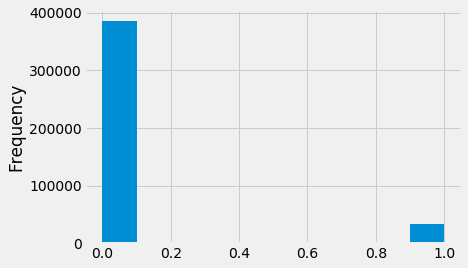

In [142]:
train['TARGET'].astype(int).plot.hist(); # 0= Normal 1= Impago

In [143]:
#Creamos Dataset
normal_df = train[train.TARGET == 0] #registros normales
impago_df = train[train.TARGET == 1] #casos de impago

In [144]:
y = train['TARGET']
X = train.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [145]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sn.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True TARGET')
    plt.xlabel('Predicted TARGET')
    plt.show()
    print (classification_report(y_test, pred_y))

In [146]:
#Ejecutamos Modelo con LogisticRegresion para poder Comparar
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
rcParams['figure.figsize'] = 14, 8.7
LABELS = ["Normal","Impago"]

In [ ]:
#Probamos como responde en el test set
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [ ]:
#Probamos con Random Forest

# Crear el modelo con 100 arboles
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,verbose=2,
                               max_features = 'sqrt')
# entrenar!
model.fit(X_train, y_train)

In [ ]:
#Revisamos los resultados
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [ ]:
# otro modelo, variando hiperparámetros
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=2, max_depth=6,
                               oob_score=True, random_state=50)
# a entrenar
model.fit(X_train, y_train)

In [ ]:
#Vemos la Confusion Matrix con el conjunto de Test
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [ ]:
#Comprobamos Resultados

# Calculate roc auc
roc_value = roc_auc_score(y_test, pred_y)

In [ ]:
print(roc_value)